# Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import KeyedVectors
import tensorflow_hub as hub

# Modeling
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data Loading and Data Analysis

In [3]:
df = pd.read_csv(r'Data\data_after_preprocessing.csv')
df.head()

,id,sentence,price,quality,environment,service,other
0,1,i ordered egg soft noodles from here they did ...,NaN,Negative,NaN,Negative,NaN
1,2,ice cream was good but it is totally got melt ...,NaN,Positive,NaN,Negative,NaN
2,2,he mentioned it as delivered as soon as he pic...,NaN,NaN,NaN,Negative,NaN
3,2,he took nearly forty five minutes to come,NaN,NaN,NaN,Negative,NaN
4,3,food was not good its from yesterdays food wit...,NaN,Negative,NaN,Negative,NaN


In [4]:
aspects = ['price', 'quality', 'environment', 'service', 'other']
df[aspects] = df[aspects].notna().astype(int)
df.head()

,id,sentence,price,quality,environment,service,other
0,1,i ordered egg soft noodles from here they did ...,0,1,0,1,0
1,2,ice cream was good but it is totally got melt ...,0,1,0,1,0
2,2,he mentioned it as delivered as soon as he pic...,0,0,0,1,0
3,2,he took nearly forty five minutes to come,0,0,0,1,0
4,3,food was not good its from yesterdays food wit...,0,1,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5288 entries, 0 to 5287
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5288 non-null   int64 
 1   sentence     5288 non-null   object
 2   price        5288 non-null   int32 
 3   quality      5288 non-null   int32 
 4   environment  5288 non-null   int32 
 5   service      5288 non-null   int32 
 6   other        5288 non-null   int32 
dtypes: int32(5), int64(1), object(1)
memory usage: 186.0+ KB


### Prepare data

In [6]:
X = df['sentence']
print('X shape:', X.shape)

Y = df[aspects]
print('y shape:', Y.shape)

X shape: (5288,)
y shape: (5288, 5)


### Data Analysis

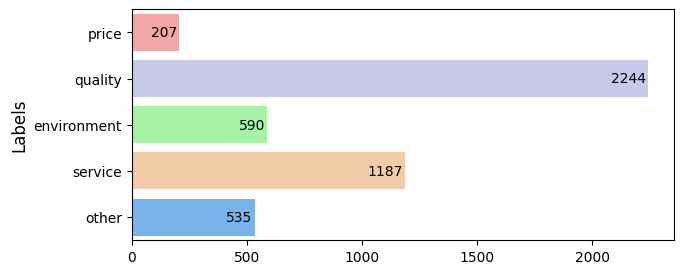

In [7]:
labels_counts = Y.sum(axis=0)
labels, counts = labels_counts.index, labels_counts.values

# Vẽ biểu đồ
plt.figure(figsize=(7, 3))
palette = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C2C2F0'] 
ax = sns.barplot(x=counts, hue=counts, legend=False, y=labels, palette=palette, orient='h')

# Thêm giá trị lên thanh
for bar in ax.patches:
    y = bar.get_y() + bar.get_height() / 2
    label = bar.get_y()  # không cần, dùng trực tiếp bar
    width = bar.get_width()
    plt.text(width - 10, y, f'{int(width)}', va='center', ha='right', color='black')

ax.set_ylabel("Labels", fontsize=12)
plt.show()

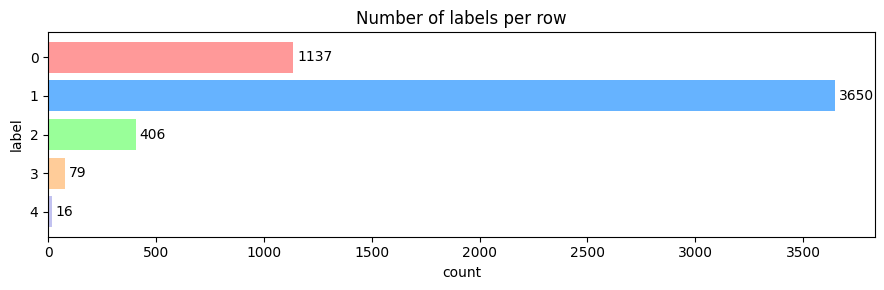

In [8]:
labels_counts = Y.sum(axis=1).value_counts().sort_index()
labels, counts = labels_counts.index, labels_counts.values

plt.figure(figsize=(9, 3))
plt.barh(labels, counts, color=palette)
max_count = counts.max()
for i, v in enumerate(counts):
    plt.text(v + max_count * 0.005, i, str(v), va='center', ha='left', color='black')
plt.xlabel("count")
plt.ylabel("label")
plt.title("Number of labels per row")
plt.barh(labels, counts, color=palette)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Embedding

### TF-IDF

In [9]:
keep_words = [
    # Negative words
    'not', 'no', 'none', 'never', 'nothing', 'nobody', 'nowhere', 'neither', 'without',
    'cannot', 'cant', 'couldnt', 'hasnt', 'nor',

    # Adjective/Adverb
    'well', 'interest',

    # Numerous
    'one', 'two', 'three', 'four', 'five', 'six', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'fifteen', 'twenty', 'forty', 'fifty', 'sixty',
    'hundred'
]
custom_stopwords = list(ENGLISH_STOP_WORDS.difference(keep_words))

In [10]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words=custom_stopwords)

def fit_tfidf(X_train_text):
    vectorizer.fit(X_train_text)

def transform_tfidf(X_text):
    return vectorizer.transform(X_text).toarray()

### USE

In [11]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
use_model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed_USE(input):
    return np.array(use_model(input))

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


### FastText

In [12]:
fastText_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False)

In [13]:
def sentence_to_vector(sentence):
    words = sentence.split()
    filtered_words = [w for w in words if w not in custom_stopwords]
    word_vectors = [fastText_model[w] for w in filtered_words if w in fastText_model]
    if not word_vectors:
        return np.zeros(fastText_model.vector_size)
    return np.mean(word_vectors, axis=0)

In [14]:
def embed_fastText(input):
    vectors = input.apply(sentence_to_vector)
    return np.vstack(vectors.values)

# Define models

In [ ]:
models = {
      "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
      "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
      "SVC": LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'),
      "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0, class_weight='balanced')
}

In [16]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    recall, precision, f1 = (
        recall_score(y_test, y_pred, average='weighted', zero_division=0),
        precision_score(y_test, y_pred, average='weighted', zero_division=0),
        f1_score(y_test, y_pred, average='weighted', zero_division=0)
    )
    return recall, precision, f1, y_test, y_pred

In [17]:
def experiment_with_kfold(X, y, embedding, model):
  kf = KFold(n_splits=5, shuffle=True)
  recalls, precisions, f1s = [], [], []

  for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    if embedding == 'TF-IDF':
      fit_tfidf(X_train)
      X_train = transform_tfidf(X_train)
      X_test = transform_tfidf(X_test)

    if embedding == 'USE':
      X_train, X_test = embed_USE(X_train), embed_USE(X_test)

    if embedding == 'FAST_TEXT':
      X_train, X_test = embed_fastText(X_train), embed_fastText(X_test)

    recall, precision, f1, _, _ = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

  return recalls, precisions, f1s

# Experiment

In [18]:
base_model = MultiOutputClassifier(models['Logistic Regression'])
Tfidf = experiment_with_kfold(X, Y, 'TF-IDF', base_model)
use = experiment_with_kfold(X, Y, 'USE', base_model)
fastText = experiment_with_kfold(X, Y, 'FAST_TEXT', base_model)

In [19]:
results_Tfidf = (pd.DataFrame(Tfidf)).T
results_Tfidf.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_Tfidf.columns = ['Recall', 'Precision', 'F1 Score']
results_Tfidf.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.760460,0.715778,0.733107
Fold 2,0.743005,0.697358,0.713714
Fold 3,0.735043,0.692132,0.709199
Fold 4,0.769312,0.717138,0.735814
Fold 5,0.747138,0.709263,0.725392


In [20]:
results_USE = (pd.DataFrame(use)).T
results_USE.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_USE.columns = ['Recall', 'Precision', 'F1 Score']
results_USE.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.831522,0.676299,0.737104
Fold 2,0.831590,0.675771,0.738525
Fold 3,0.834872,0.675250,0.739264
Fold 4,0.872407,0.701187,0.767951
Fold 5,0.834388,0.668276,0.734896


In [21]:
results_FAST_TEXT = (pd.DataFrame(fastText)).T
results_FAST_TEXT.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_FAST_TEXT.columns = ['Recall', 'Precision', 'F1 Score']
results_FAST_TEXT.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.793750,0.628561,0.690745
Fold 2,0.782609,0.616075,0.679119
Fold 3,0.773869,0.652732,0.698587
Fold 4,0.794926,0.621571,0.687588
Fold 5,0.789989,0.595322,0.668312


**Vì đây là bài toán xác định các khía cạnh có trong câu nên ta cần chú trọng vào tỉ lệ Recall hơn**

In [22]:
recall_tfidf, precision_tfidf, f1_tfidf = Tfidf
recall_use, precision_use, f1_use = use
recall_fastText, precision_fastText, f1_fastText = fastText

f_stat, p_val = stats.f_oneway(recall_tfidf, recall_use, recall_fastText)
print(f"F-statistic: {f_stat:.10f}")
print(f"p-value: {p_val:.10f}")

F-statistic: 53.1713094310
p-value: 0.0000010870


Với p-value < 0.05, ta bác bỏ giả thuyết H₀ ("Không có sự khác biệt giữa các phương pháp").

Điều này cho thấy sự khác biệt giữa TF-IDF, USE và FastText là có ý nghĩa thống kê.

Tiếp điến ta tiến hành kiểm nghiệm giữa từng cặp phương pháp embedding

In [23]:
scores = recall_tfidf + recall_use + recall_fastText
methods = ['TF-IDF'] * len(recall_tfidf) + ['USE'] * len(recall_use) + ['FAST_TEXT'] * len(recall_fastText)

tukey_df = pd.DataFrame({'recall': scores, 'method': methods})

tukey = pairwise_tukeyhsd(endog=tukey_df['recall'], groups=tukey_df['method'], alpha=0.05)
print("\nTukey HSD kết quả:")
print(tukey)

# Gợi ý chọn phương pháp tốt nhất
mean_scores = tukey_df.groupby('method')['recall'].mean().sort_values(ascending=False)
print("\nPhương pháp có recall trung bình cao nhất:", mean_scores.index[0])
print(mean_scores)


Tukey HSD kết quả:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
FAST_TEXT TF-IDF   -0.036 0.0039 -0.0595 -0.0126   True
FAST_TEXT    USE   0.0539 0.0001  0.0305  0.0774   True
   TF-IDF    USE     0.09    0.0  0.0665  0.1134   True
-------------------------------------------------------

Phương pháp có recall trung bình cao nhất: USE
method
USE          0.840956
FAST_TEXT    0.787029
TF-IDF       0.750992
Name: recall, dtype: float64


Sau khi tiến hành kiểm định hậu nghiệm Tukey HSD, ta thấy sự khác biệt giữa các cặp phương pháp đều mang ý nghĩa thống kê (p < 0.05). 

Trong đó, phương pháp USE đạt recall trung bình cao nhất (0.8388), cao hơn đáng kể so với fastText và TF-IDF. 

Do đó, **USE** được chọn là phương pháp embedding tối ưu cho mô hình trong bài toán nhận diện khía cạnh.

## Modeling
USE

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_vec, X_test_vec = embed_USE(X_train), embed_USE(X_test)

In [41]:
results = []
for model_name, model in models.items():

    model = MultiOutputClassifier(model)

    recall, precision, f1, _, _ = train_and_evaluate(model, X_train_vec, y_train, X_test_vec, y_test)
    results.append({'Model': model_name,
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1})

results_df = pd.DataFrame(results)
results_df.style.highlight_max(subset=['Recall', 'Precision', 'F1 Score'], axis=0, color='lightgreen')

,Model,Recall,Precision,F1 Score
0,Logistic Regression,0.831414,0.675699,0.738201
1,Random Forest,0.524607,0.868238,0.616160
2,SVC,0.693194,0.797045,0.739245
3,XGBoost,0.649215,0.817356,0.717284


### Conclusion

Từ kết quả trên ta thấy mô hình Logistic Regression cho kết quả tốt nhất nên ta lựa chọn mô hình này cho phần Aspect detection

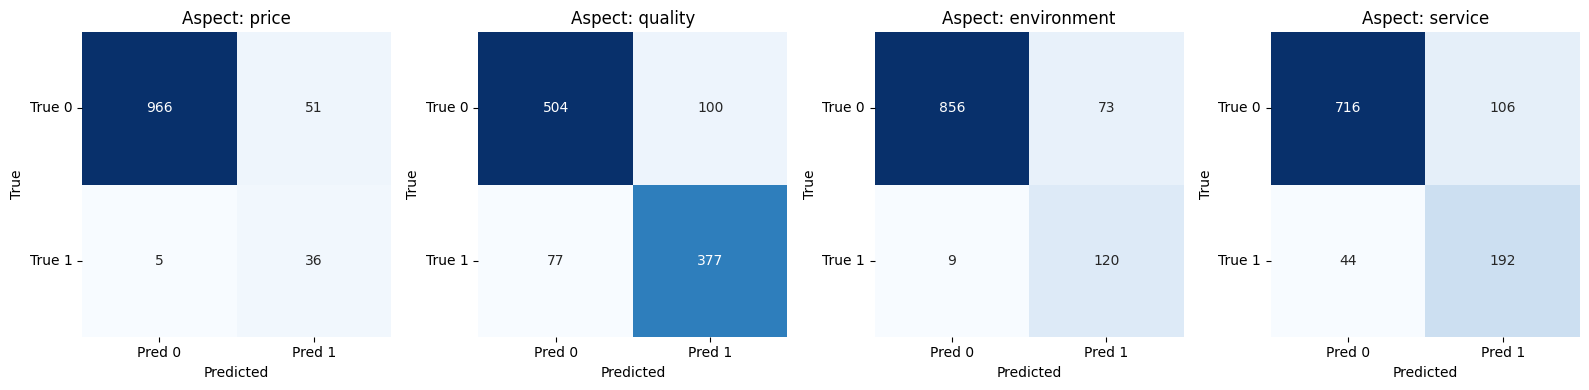

In [42]:
model = MultiOutputClassifier(models['Logistic Regression'])
_, _, _, y_test, y_pred = train_and_evaluate(model, X_train_vec, y_train, X_test_vec, y_test)
cm_all = multilabel_confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, aspect in enumerate(['price', 'quality', 'environment', 'service']):
    cm = cm_all[i]
    cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])

    ax = axes[i]
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Aspect: {aspect}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_yticklabels(['True 0', 'True 1'], rotation=0)

plt.tight_layout()
plt.show()

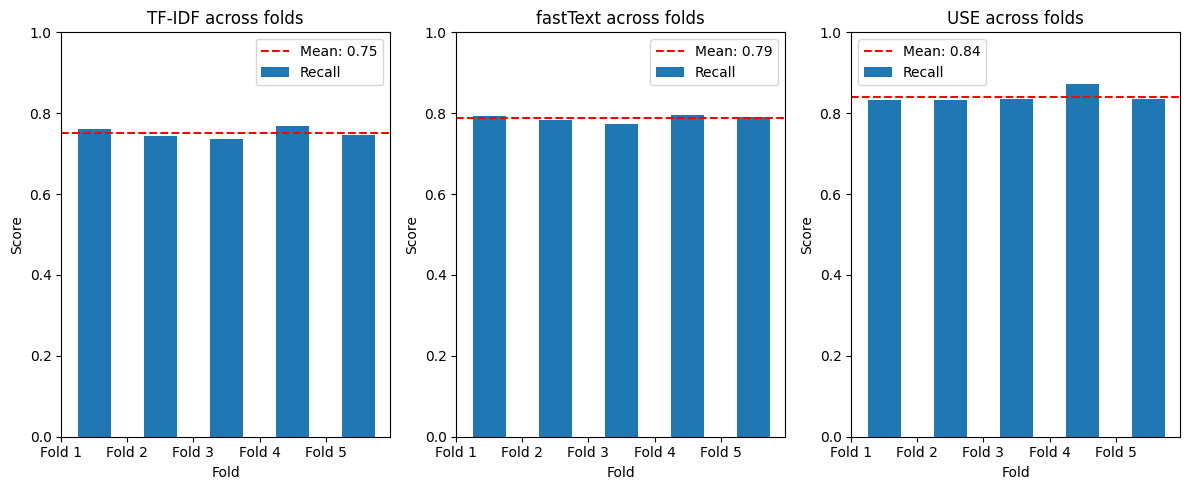

In [ ]:
# Visualization
folds = np.arange(1, 6)
x = np.arange(len(folds)) 
bar_width = 0.5

recall_tfidf = np.array(recall_tfidf)
recall_fastText = np.array(recall_fastText)
recall_use = np.array(recall_use)

# Calculate mean recall for each method
mean_recall_tfidf = recall_tfidf.mean()
mean_recall_use = recall_use.mean()
mean_recall_fastText = recall_fastText.mean()

plt.figure(figsize=(12, 5))

# -------- TF-IDF --------
plt.subplot(1, 3, 1)
plt.bar(x + bar_width, recall_tfidf, width=bar_width, label='Recall')
plt.axhline(mean_recall_tfidf, color='red', linestyle='--', label=f'Mean: {mean_recall_tfidf:.2f}')
plt.title('TF-IDF across folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(x, [f'Fold {i}' for i in folds])
plt.ylim(0, 1)
plt.legend()

# -------- fastText --------
plt.subplot(1, 3, 2)
plt.bar(x + bar_width, recall_fastText, width=bar_width, label='Recall')
plt.axhline(mean_recall_fastText, color='red', linestyle='--', label=f'Mean: {mean_recall_fastText:.2f}')
plt.title('fastText across folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(x, [f'Fold {i}' for i in folds])
plt.ylim(0, 1)
plt.legend()

# -------- USE --------
plt.subplot(1, 3, 3)
plt.bar(x + bar_width, recall_use, width=bar_width, label='Recall')
plt.axhline(mean_recall_use, color='red', linestyle='--', label=f'Mean: {mean_recall_use:.2f}')
plt.title('USE across folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(x, [f'Fold {i}' for i in folds])
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()
